# Data Exploration in R
This notebook demonstrates basic data exploration for futures data using R.

## Import Libraries

In [1]:
library(arrow)
library(dplyr)
library(lubridate)
library(tidyr)
library(data.table)
library(ggplot2)
library(urca)
library(tseries)
library(xts)
library(KFAS)
library(RcppRoll)
library(PerformanceAnalytics)


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following object is masked from ‘package:arrow’:

    duration


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:data.table’:

    yearmon, yearqtr

## Pre-Processing

In [2]:
bars <- read_parquet('../data/processed/ZNZF_1m.parquet')
head(bars)
glimpse(bars)

ts_event,ZN,ZF
<dttm>,<dbl>,<dbl>
2018-01-02 00:00:00,124.0000,116.1406
2018-01-02 00:01:00,124.0000,116.1406
2018-01-02 00:03:00,123.9844,116.1406
2018-01-02 00:04:00,123.9844,116.1406
2018-01-02 00:05:00,123.9844,116.1406
2018-01-02 00:07:00,123.9844,116.1406


Rows: 2,425,429
Columns: 3
$ ts_event <dttm> 2018-01-02 00:00:00, 2018-01-02 00:01:00, 2018-01-02 00:03:0…
$ ZN       <dbl> 124.0000, 124.0000, 123.9844, 123.9844, 123.9844, 123.9844, 1…
$ ZF       <dbl> 116.1406, 116.1406, 116.1406, 116.1406, 116.1406, 116.1406, 1…


In [3]:
bars_rth <- bars %>% 
  mutate(dt = with_tz(ts_event, "UTC"),
         time = hms::as_hms(dt)) %>%
  filter(time >= hms::parse_hms("13:20:00"),
         time <= hms::parse_hms("20:30:00")) %>%
  arrange(ts_event) %>%
  tidyr::fill(ZN, ZF, .direction = "down")

# convert to data.table for speed
setDT(bars_rth)

In [4]:
# bars_rth already contains RTH minutes and forward-filled prices
# -----------------------------------------------------------------
# 1.  Hard sanity floor / ceiling
#    • 5- and 10-year notes have not traded below 80 or above 150
#      in the modern era.  Adjust bounds if you add earlier history.
# -----------------------------------------------------------------
bars_rth <- bars_rth %>%
  filter(between(ZN, 80, 150),
         between(ZF, 70, 140))

# 2.  Forward-fill again so the minute grid stays complete
bars_rth <- tidyr::fill(bars_rth, ZN, ZF, .direction = "down")
# If you prefer data.table API
setDT(bars_rth)


# Mean-Reversion Data Exploaration

In [5]:
pa <- bars_rth$ZN
pb <- bars_rth$ZF

cat("Pearson correlation:", cor(pa, pb), "\n")

beta_static <- mean(pa / pb, na.rm = TRUE)
spread_static <- pa - beta_static * pb

adf <- urca::ur.df(spread_static, type = "drift", lags = 1)
cat("ADF p-value:", adf@teststat[1], "\n")

# Spread half-life (Ornstein–Uhlenbeck)
hl_fit <- ar(spread_static, aic = FALSE, order.max = 1, demean = TRUE)
phi <- hl_fit$ar
half_life <- -log(2) / log(abs(phi))
cat("Half-life (minutes):", round(half_life), "\n")

Pearson correlation: 0.9935173 


ADF p-value: -18.75177 
Half-life (minutes): 227 


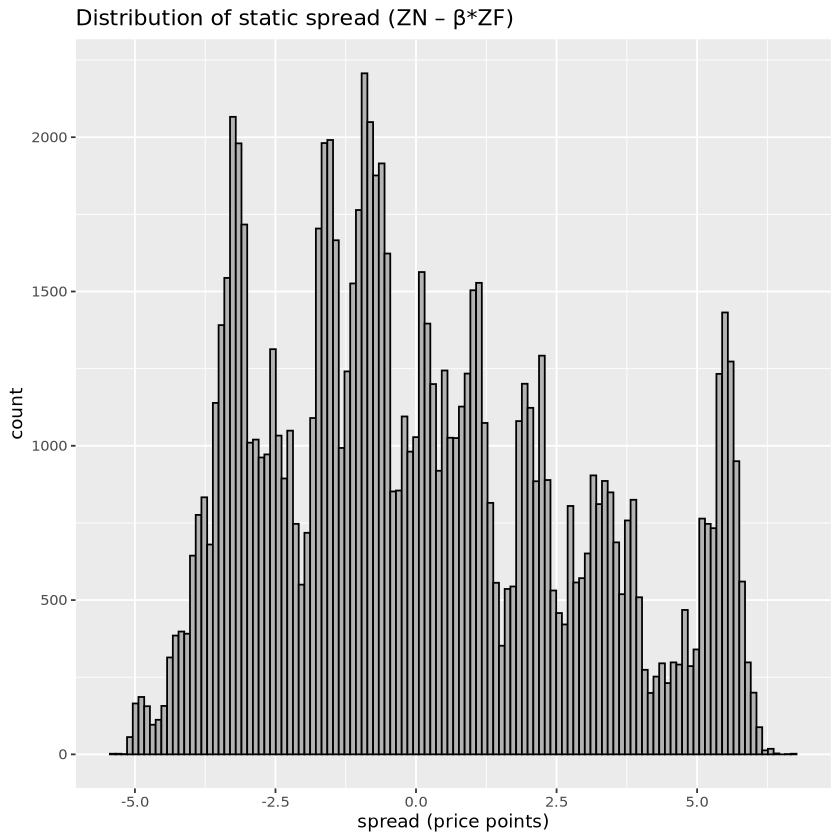

In [6]:
# Ensure bars_rth is a data.table and spread_static is attached
setDT(bars_rth)
bars_rth[, spread_static := ZN - beta_static * ZF]   # attach once

# ================================================================
# 5A  Histogram of static spread
# ================================================================
ggplot(bars_rth[sample(.N, 100000)],                 # 100k-row subsample
       aes(x = spread_static)) +
  geom_histogram(bins = 120, fill = "grey70", colour = "black") +
  labs(title = "Distribution of static spread (ZN – β*ZF)",
       x = "spread (price points)", y = "count")

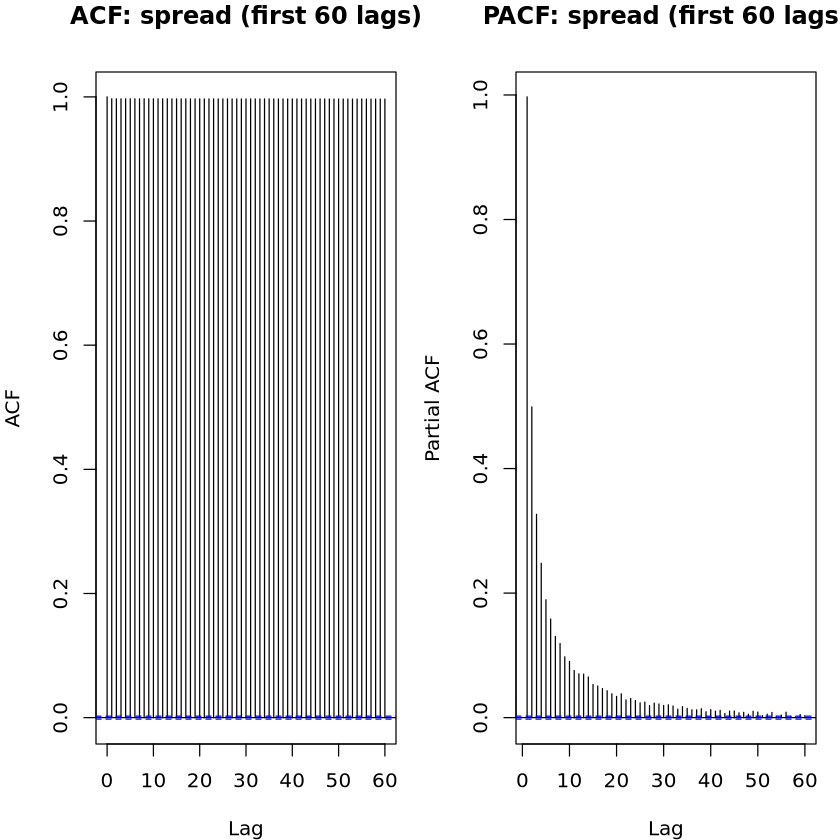

In [7]:
# ================================================================
# 5B  Autocorrelation (ACF) and Partial ACF (PACF)
# ================================================================
par(mfrow = c(1, 2), mar = c(4, 4, 3, 1))            # 2 plots side-by-side
acf(bars_rth$spread_static,  lag.max = 60,
    main = "ACF: spread (first 60 lags)")
pacf(bars_rth$spread_static, lag.max = 60,
     main = "PACF: spread (first 60 lags)")
par(mfrow = c(1, 1))                                 # reset layout

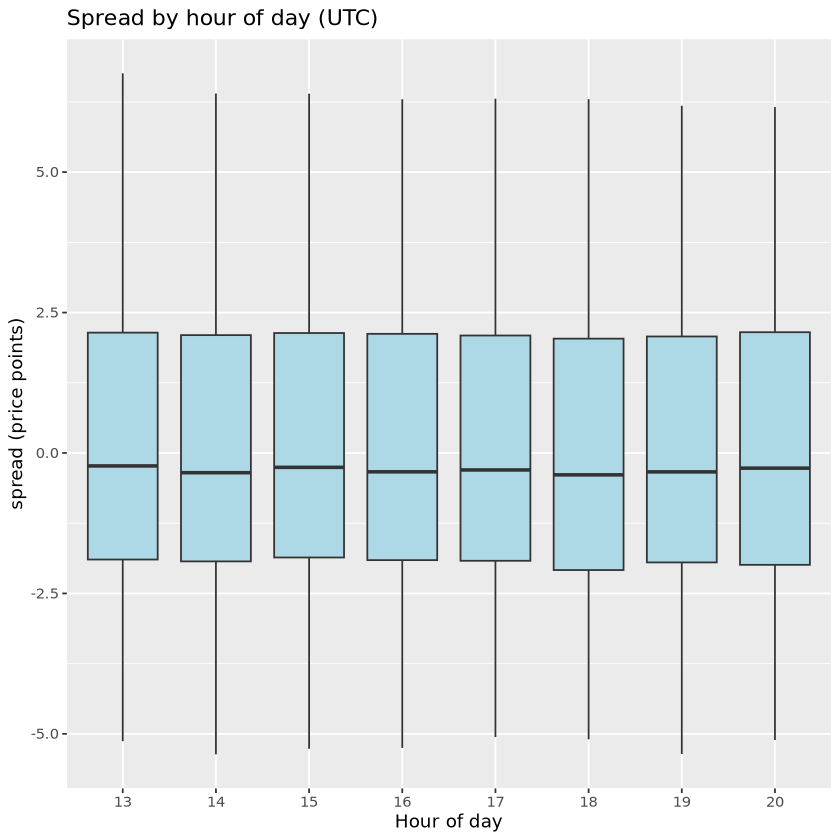

In [8]:
# ================================================================
# 5C  Intraday seasonality: spread by hour-of-day (UTC)
# ================================================================
bars_rth[, hod := hour(ts_event)]                    # add hour column

ggplot(bars_rth[sample(.N, 150000)],                 # subsample for speed
       aes(x = factor(hod), y = spread_static)) +
  geom_boxplot(outlier.size = 0.35, fill = "lightblue") +
  labs(title = "Spread by hour of day (UTC)",
       x = "Hour of day", y = "spread (price points)")

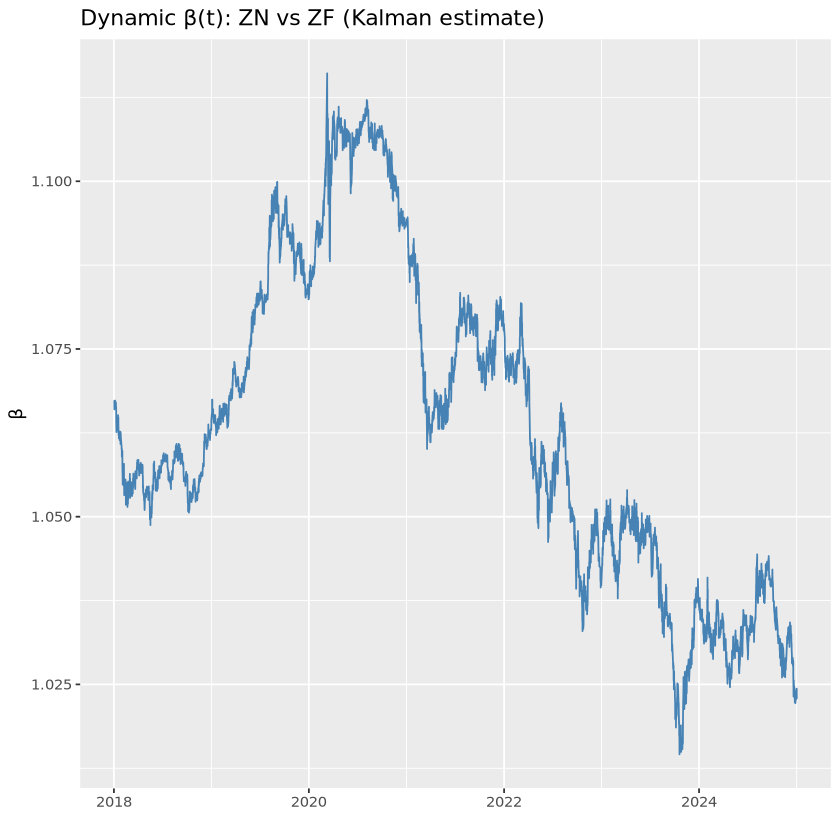

In [9]:

setDT(bars_rth)

# 1. Kalman state‑space model: level β(t) and intercept α(t)
y <- ts(cbind(bars_rth$ZN, bars_rth$ZF))

kmod <- SSModel(
  y ~ SSMtrend(degree = 1, Q = diag(1e-4, 2)),   # state variance
  H = diag(1e-2, 2)                              # obs variance
)

kf <- KFS(kmod, filtering = "state")
state <- kf$a[-1, ]    # skip first row (initial state)
bars_rth[, `:=`(
  beta_dyn  = state[, 1] / state[, 2],
  alpha_dyn = state[, 2]
)]

# 2. Plot β(t) every 60th minute to keep file light
library(ggplot2)
ggplot(bars_rth[seq(1, .N, by = 60)],
       aes(ts_event, beta_dyn)) +
  geom_line(color = "steelblue") +
  labs(title = "Dynamic β(t): ZN vs ZF (Kalman estimate)",
       x = "", y = "β")


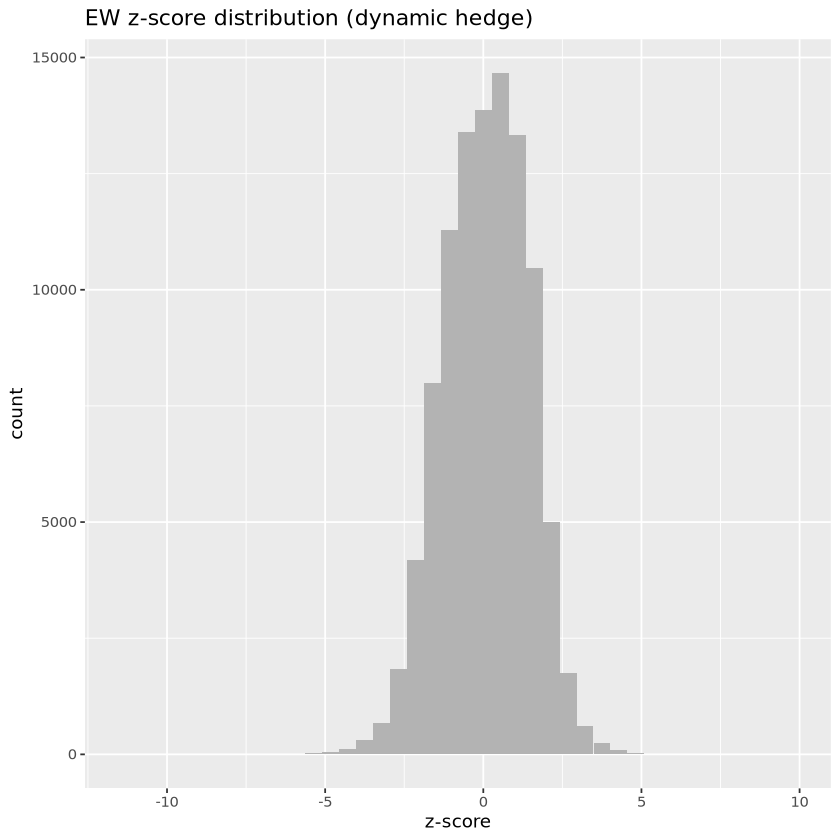

In [ ]:
k <- 0.01  # EW alpha
spread_dyn <- with(bars_rth, ZN - beta_dyn * ZF - alpha_dyn)

# rolling EW mean & var (length 1/k ≈ 100 mins effective)
mu  <- RcppRoll::roll_mean(spread_dyn, n = 2000, fill = NA, align = "right")
sig <- sqrt(RcppRoll::roll_var(spread_dyn, n = 2000, fill = NA, align = "right"))

bars_rth[, z := (spread_dyn - mu) / sig]

ggplot(bars_rth[!is.na(z)][sample(.N, 100000)],
       aes(z)) +
  geom_histogram(bins = 30, fill = "grey70") +
  labs(title = "EW z‑score distribution (dynamic hedge)",
       x = "z‑score", y = "count")


In [11]:
ret <- diff(spread_dyn)                # minute‑to‑minute spread change
xt  <- xts::xts(ret, order.by = bars_rth$ts_event[-1])

sharpe <- SharpeRatio.annualized(
  xt, scale = 252 * 6.5 * 12, geometric = FALSE)

cat("Raw spread-change Sharpe:", round(as.numeric(sharpe), 2), "\n")


Raw spread-change Sharpe: 0.01 


In [13]:
bars_trd <- bars_rth[!is.na(z)]         # drop warm‑up rows
bars_trd[, `:=`(pos = 0L, pnl = 0)]

p <- 0L
for (i in 2:nrow(bars_trd)) {
  z <- bars_trd$z[i]
  if (p != 0 && (abs(z) < EXIT || abs(z) > STOP)) p <- 0L
  if (p == 0 && abs(z) > ENTRY)                    p <- -sign(z)

  bars_trd$pos[i] <- p
  bars_trd$pnl[i] <- bars_trd$pnl[i-1] +
                     p * (bars_trd$spread_dyn[i] -
                          bars_trd$spread_dyn[i-1])
}


ERROR: Error in bars_trd$pnl[i] <- bars_trd$pnl[i - 1] + p * (bars_trd$spread_dyn[i] - : replacement has length zero
